# Experimentation and Uplift Testing

Trial stores were performed in stores 77, 86 and 88

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

pd.options.mode.chained_assignment = None  

In [3]:
# customer_data = pd.read_csv('QVI_purchase_behaviour.csv')
# transaction_data = pd.read_excel('QVI_transaction_data.xlsx')

#cleaned transaction_data merged with customer_data
data = pd.read_csv('QVI_data.csv', parse_dates=['DATE']) 

## I. Data processing
Prepare all needed measures and tables for analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.2+ MB


In [5]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


We need to define the measures for our stores. We calculate these measures for the following:
- total sales of chips
- number of customers
- average number of transactions per customer
- avergae number of chips bought per customer
- average price per unit of chips

In [6]:
def calculate_measures(data) -> pd.DataFrame:
    """
    Function to calculate for measures of each store per month.
    This will return a DataFrame with the needed measurements.
    """
    
    data['YEARMONTH'] = data.DATE.dt.strftime("%Y%m").astype(int)
    
    measures = data.groupby(['STORE_NBR','YEARMONTH'])\
                   .agg({"TXN_ID":"count",
                         "TOT_SALES":"sum",
                         "PROD_QTY":"sum",
                         "LYLTY_CARD_NBR":"nunique"})\
                   .reset_index()\
                   .rename(columns={"TXN_ID":"TXN_COUNT",
                                    "LYLTY_CARD_NBR":"CUST_COUNT"})
                                                                        
    measures['TXN_PER_CUST'] = measures.TXN_COUNT/measures.CUST_COUNT
    measures['CHPS_PER_CUST'] = measures.PROD_QTY/measures.CUST_COUNT
    measures['PRICE_PER_UNIT'] = measures.TOT_SALES/measures.PROD_QTY
    
    return measures

There are 3 trials which began in Feb 2019 until Apr 2019. In order to compare with a control group, we would need to have a control group with the following criteria:
- stores with a complete set of months (complete data for all 12 months)
- stores with pre-trial measures, such as correlation and magnitude distance, having the closest similarity to our trial stores

In [7]:
def correlation(t_store_nbr, c_store_nbr, columns, measures) -> pd.DataFrame:
    """
    Function to calculate for the correlation of each control store
    to the given trial store
    """
    
    corr_dict = {"YEARMONTH": [],
                 "TRIAL_STORE_NBR": [],
                 "CONTROL_STORE_NBR": [],
                 "CORR_SCORE": []}

    for i in c_store_lst:

        trial_store = measures[measures.STORE_NBR==t_store_nbr]
        control_store = measures[measures.STORE_NBR==i]

        corr_dict["YEARMONTH"].extend(trial_store['YEARMONTH'].to_list())
        corr_dict['TRIAL_STORE_NBR'].extend(trial_store['STORE_NBR'].to_list())
        corr_dict['CONTROL_STORE_NBR'].extend(control_store['STORE_NBR'].to_list())
        corr_dict["CORR_SCORE"].extend(trial_store[columns].reset_index()\
                               .corrwith(control_store[columns].reset_index(),
                                axis=1,method='pearson',drop=True).to_list())
        
    return pd.DataFrame(corr_dict)

We can also calculate the magnitude distance for each measure

In [8]:
def magnitude_distance(t_store_nbr, c_store_nbr, columns, measures) -> pd.DataFrame:
    """
    Function to calculate for the magnitude distance. This
    will return standardized distances for each column.
    """    
    
    df1 = measures[measures.STORE_NBR==t_store_nbr][columns].reset_index(drop=True)
    
    distance = []
    for i in c_store_nbr:
        
        control = measures[measures.STORE_NBR==i]
        df2 = control[columns].reset_index(drop=True)
        diff = abs(df1.subtract(df2))

        diff['CONTROL_STORE_NBR'] = i
        diff['YEARMONTH'] = control['YEARMONTH'].to_list()

        distance.append(diff)
        
    final = pd.concat(distance)
    final['TRIAL_STORE_NBR'] = t_store_nbr

    for col in columns:
        final[col] = 1 - ((final[col]-final[col].min())/(final[col].max()-final[col].min()))
    
    #we average the magnitude distance for each store and month
    final['MAG_SCORE'] = final[columns].mean(axis=1)

    return final[['YEARMONTH','TRIAL_STORE_NBR','CONTROL_STORE_NBR','MAG_SCORE']]

To rank the stores, we can take the average of our correlation and distance measurements for each store.

In [9]:
def combined_measures(t_store_nbr, c_store_nbr, columns, measures):
    """
    This function will call both correlation() and magnitude_distance()
    to average their measures for a final control score
    """
    
    indices = ['YEARMONTH','TRIAL_STORE_NBR','CONTROL_STORE_NBR']
    
    corr_measure = correlation(t_store_nbr, c_store_nbr, columns, measures)
    mag_measure = magnitude_distance(t_store_nbr, c_store_nbr, columns, measures)
    
    combined = corr_measure.merge(mag_measure, on=indices)
    combined['CONTROL_SCORE'] = (combined.CORR_SCORE*0.5) + (combined.MAG_SCORE*0.5)
    
    return combined.groupby(['TRIAL_STORE_NBR','CONTROL_STORE_NBR']).mean().reset_index()

In [10]:
measures = calculate_measures(data)
pre_trial_measures = measures[measures.YEARMONTH < 201902]
trial_measures = measures[(measures.YEARMONTH >= 201902)&(measures.YEARMONTH <= 201904)]

c_store_lst = measures.groupby('STORE_NBR')['YEARMONTH'].count().reset_index()
c_store_lst = c_store_lst[c_store_lst.YEARMONTH == 12]['STORE_NBR'].to_list()

In [11]:
columns = ['TOT_SALES']
print(f"For columns: {columns}")
print("Top 3 control stores for each trial store within the pre-trial period:","\n")
for t in [77,86,88]:
    combined = combined_measures(t, c_store_lst, columns, pre_trial_measures)
    top_3 = combined[~combined.CONTROL_STORE_NBR.isin([77,86,88])]\
                              .sort_values('CONTROL_SCORE',
                                           ascending=False)\
                                           [['CONTROL_STORE_NBR','CONTROL_SCORE']]\
                              .drop_duplicates('CONTROL_STORE_NBR')\
                              .reset_index(drop=True).head(3)
    print(f"Trial store {t}:\n{top_3}","\n")

For columns: ['TOT_SALES']
Top 3 control stores for each trial store within the pre-trial period: 

Trial store 77:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                233       0.993238
1                255       0.989739
2                188       0.988831 

Trial store 86:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                109       0.983289
1                155       0.982836
2                222       0.981038 

Trial store 88:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                 40       0.970582
1                 26       0.952189
2                 72       0.951900 



In [12]:
columns=['CUST_COUNT']
print(f"For columns: {columns}")
print("Top 3 control stores for each trial store within the pre-trial period:","\n")
for t in [77,86,88]:
    combined = combined_measures(t, c_store_lst, columns, pre_trial_measures)
    top_3 = combined[~combined.CONTROL_STORE_NBR.isin([77,86,88])]\
                              .sort_values('CONTROL_SCORE',
                                           ascending=False)\
                                           [['CONTROL_STORE_NBR','CONTROL_SCORE']]\
                              .drop_duplicates('CONTROL_STORE_NBR')\
                              .reset_index(drop=True).head(3)
    print(f"Trial store {t}:\n{top_3}","\n")

For columns: ['CUST_COUNT']
Top 3 control stores for each trial store within the pre-trial period: 

Trial store 77:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                233       0.996566
1                 41       0.988324
2                111       0.984203 

Trial store 86:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                155       0.993386
1                225       0.984788
2                109       0.984788 

Trial store 88:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                237       0.993909
1                203       0.972315
2                 40       0.971207 



## II. Analyzing data for trial and control measures
Pre-trial months occur before April 2019. We will gather measures for each store similarly to our previous task with customer segmentation.

In [13]:
measures.head()

,STORE_NBR,YEARMONTH,TXN_COUNT,TOT_SALES,PROD_QTY,CUST_COUNT,TXN_PER_CUST,CHPS_PER_CUST,PRICE_PER_UNIT
0,1,201807,52,206.9,62,49,1.061224,1.265306,3.337097
1,1,201808,43,176.1,54,42,1.023810,1.285714,3.261111
2,1,201809,62,278.8,75,59,1.050847,1.271186,3.717333
3,1,201810,45,188.1,58,44,1.022727,1.318182,3.243103
4,1,201811,47,192.6,57,46,1.021739,1.239130,3.378947


### Total sales per month
We analyze the sales per month of our trial store and control stores.

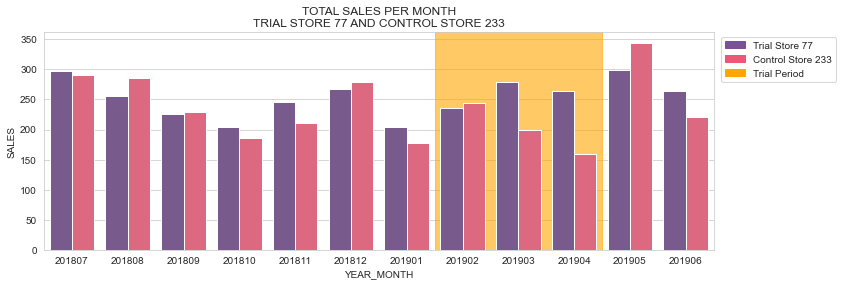

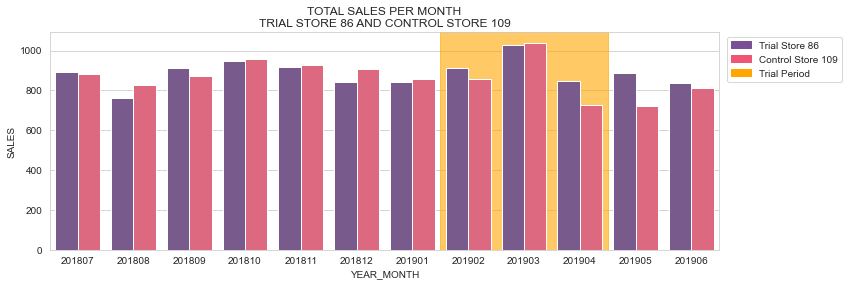

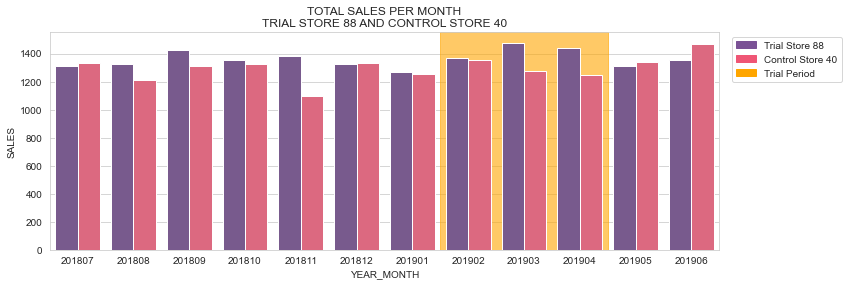

In [14]:
sns.set_style("whitegrid")
colorList = ['#7a5195','#ef5675','#ffa600']
trials, controls = [77,86,88], [233,109,40]

for trial, control in zip(trials, controls):
    labelList = [f"Trial Store {trial}",f"Control Store {control}",'Trial Period']
    handles = [mpatches.Patch(color=color, label=label)\
               for color, label in zip(colorList,labelList)]

    data_c =  measures[measures.STORE_NBR.isin([trial,control])]

    plt.figure(figsize=(12,4))
    plt.axvspan(6.5,9.5,
                color='#ffa600',
                alpha=0.6)
    sns.barplot(data=data_c, 
                x='YEARMONTH', 
                y='TOT_SALES', 
                hue='STORE_NBR',
                hue_order=[trial,control],
                palette=colorList)
    plt.title(f'TOTAL SALES PER MONTH\nTRIAL STORE {trial} AND CONTROL STORE {control}')
    plt.xlabel('YEAR_MONTH')
    plt.ylabel('SALES')
    plt.legend(handles=handles,
               loc="upper right",
               bbox_to_anchor=(1.19,1))
    plt.show()

### Number of customers per month

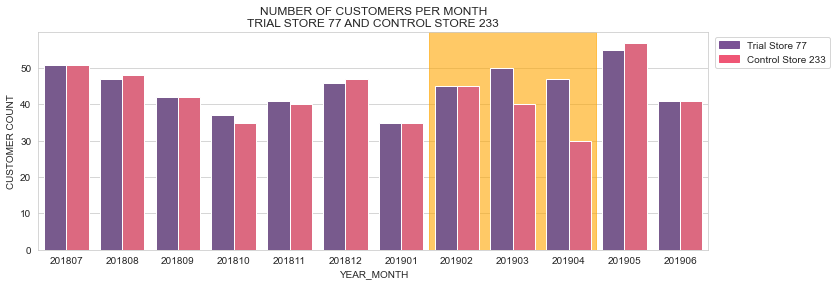

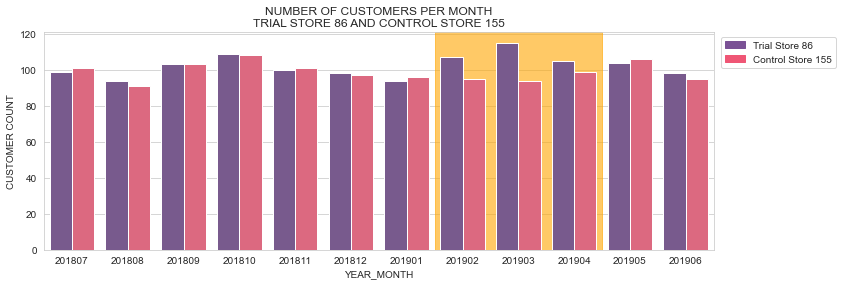

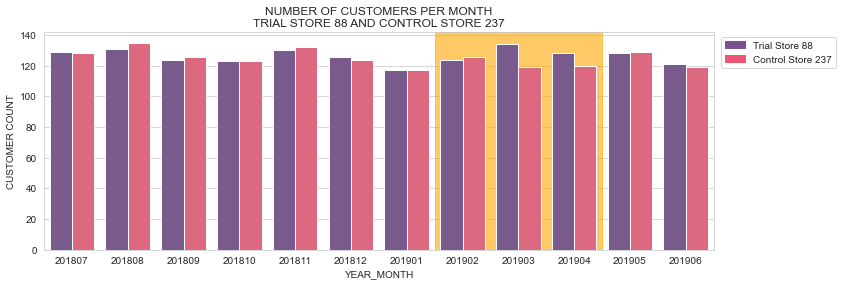

In [22]:
controls = [233,155,237]

for trial, control in zip(trials, controls):
    labelList = [f"Trial Store {trial}",f"Control Store {control}",'Trial Period']
    handles = [mpatches.Patch(color=color, label=label)\
               for color, label in zip(colorList,labelList)]

    data_c =  measures[measures.STORE_NBR.isin([trial,control])]

    plt.figure(figsize=(12,4))
    plt.axvspan(6.5,9.5,
                color='#ffa600',
                alpha=0.6)
    sns.barplot(data=data_c, 
                x='YEARMONTH', 
                y='CUST_COUNT', 
                hue='STORE_NBR',
                hue_order=[trial,control],
                palette=colorList)
    plt.title(f'NUMBER OF CUSTOMERS PER MONTH\nTRIAL STORE {trial} AND CONTROL STORE {control}')
    plt.xlabel('YEAR_MONTH')
    plt.ylabel('CUSTOMER COUNT')
    plt.legend(handles=handles,
               loc="upper right",
               bbox_to_anchor=(1.19,1))
    plt.show()

### Scaling pre-trial sales
We would want to find if there has been an uplift during the trial period for the overall chip sales. In order to do this, we need to scale the control store's sales to a level similar to that of the trial store during the pre-trial period.

In [16]:
trials, controls = [77,86,88], [233,109,40]
scaled_measures = measures[measures.STORE_NBR.isin(controls)]\
                                   .rename(columns={'STORE_NBR':'CONTROL_STORE_NBR'})\
                                   .reset_index(drop=True)
scales = []
for trial, control in zip(trials, controls):
    scaling_factor = pre_trial_measures[pre_trial_measures.STORE_NBR==trial].TOT_SALES.sum() / \
                     pre_trial_measures[pre_trial_measures.STORE_NBR==control].TOT_SALES.sum()
    scales.extend(measures[measures.STORE_NBR==control]['TOT_SALES'].apply(lambda sale: sale*scaling_factor))

scaled_measures['SCALED_TOT_SALES'] = scales 
scaled_measures['TRIAL_STORE_NBR'] = scaled_measures.CONTROL_STORE_NBR.apply(\
                                     lambda row: 77 if row==controls[0] else (86 if row==controls[1] else 88)) 
trial_sales = measures[measures.STORE_NBR.isin(trials)][['STORE_NBR','YEARMONTH','TOT_SALES']]\
                                         .rename(columns={'STORE_NBR':'TRIAL_STORE_NBR'})
scaled_measures = scaled_measures[['TRIAL_STORE_NBR','CONTROL_STORE_NBR','YEARMONTH','SCALED_TOT_SALES']]\
                                    .merge(trial_sales, on=['TRIAL_STORE_NBR','YEARMONTH'])
scaled_measures['PERCENT_DIFF'] = (abs(scaled_measures['TOT_SALES']-scaled_measures['SCALED_TOT_SALES'])/\
                                       scaled_measures['TOT_SALES'])*100

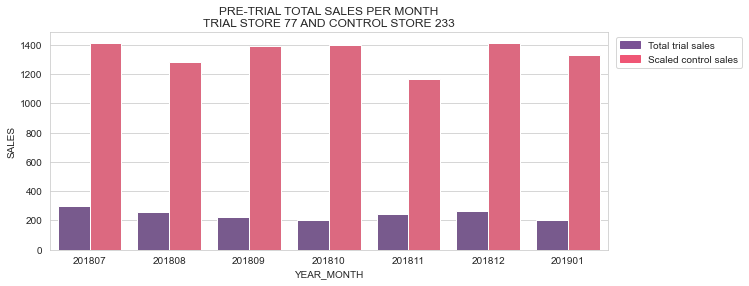

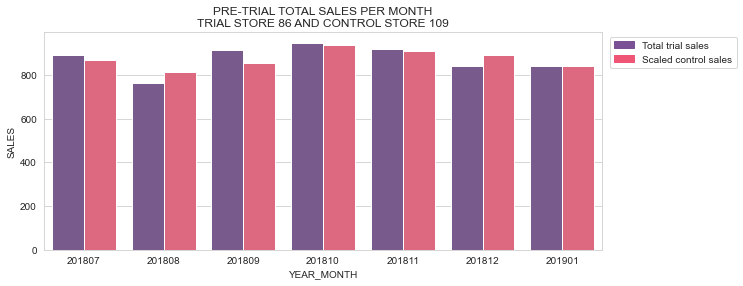

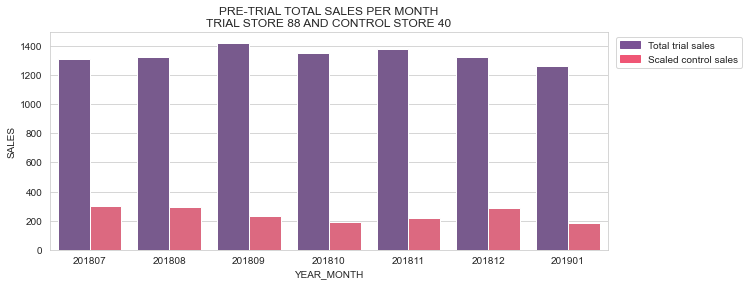

In [18]:
pre_scaled_m = scaled_measures[(scaled_measures.YEARMONTH < 201902)]

for trial, control in zip(trials, controls):
    data_c = pre_scaled_m[pre_scaled_m.TRIAL_STORE_NBR==trial]\
                                      .melt(id_vars=['YEARMONTH'], 
                                            value_vars=['TOT_SALES','SCALED_TOT_SALES'])

    colorList = ['#7a5195','#ef5675']
    labelList = ["Total trial sales",'Scaled control sales']
    handles = [mpatches.Patch(color=color, label=label)\
               for color, label in zip(colorList,labelList)]

    plt.figure(figsize=(10,4))
    sns.barplot(data=data_c, 
                x='YEARMONTH', 
                y='value', 
                hue='variable',
                palette=colorList)
    plt.title(f'PRE-TRIAL TOTAL SALES PER MONTH\nTRIAL STORE {trial} AND CONTROL STORE {control}')
    plt.xlabel('YEAR_MONTH')
    plt.ylabel('SALES')
    plt.legend(handles=handles,
               loc="upper right",
               bbox_to_anchor=(1.25,1))
    plt.show()

### Hypothesis Testing for pre-trial period
We compare control and trial stores' pre-trial sales and check if there is any significant differences. For our NULL hypothesis, we assume that the trial period is just similar with the pre-trial period. A significance of 5% is set as our alpha value.

In [23]:
from scipy.stats import ttest_ind, t

In [ ]:
for trial, control in zip(trials,controls):
    t1 = pre_scaled_m[pre_scaled_m.TRIAL_STORE_NBR==trial]['TOT_SALES']
    t2 = pre_scaled_m[pre_scaled_m.TRIAL_STORE_NBR==control]['SCALED_TOT_SALES']

    